In [18]:
import datetime
import pickle
from itertools import product

import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from ts_package.plot import plot_time_series, tsplot
from ts_package.preprocessing.smoothing import common_moving_average, exponential_smoothing, double_exponential_smoothing
from ts_package.preprocessing.boxcox import boxcox_3p, invboxcox
from ts_package.validation.metric import BusinessSimulation

In [2]:
import warnings


warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

**../data/features.csv** содержит исходные наблюдения временного ряда и дополнительные внешние факторы такие как лаги целевой переменной, макроэкономические данные, индекс МосБиржи и т. д.


Анализ набора данных в ноутбуке **./notebooks/Dataset_overview.ipynb**

In [3]:
df = pd.read_csv('../data/features.csv', index_col=0, parse_dates=['Date']).set_index('Date')
df.head()

,Income,Outcome,Balance,Налог на прибыль (при уплате только ежеквартальных авансовых платежей),Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца),Праздники РФ,Inflation Rate MoM: actual,Inflation Rate MoM: forecastCorrection,Balance of Trade: actual,Balance of Trade: forecastCorrection,...,BZ=F,IMOEX.ME,USDRUB=X,Balance lag 1,Balance lag 2,Balance lag 3,Balance lag 4,Balance lag 5,Balance lag 6,Balance lag 7
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.340000,1.490000,-0.155904,0.0,0.600000,0.0,0.6,-0.1,11.45,-0.65,...,54.939999,2211.250000,59.564999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1.068610,1.194182,-0.125572,0.0,0.666667,0.0,0.6,-0.1,11.45,-0.65,...,53.639999,2237.489990,60.102501,-0.155904,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,0.944429,0.936663,0.007767,0.0,0.733333,0.0,0.6,-0.1,11.45,-0.65,...,55.099998,2218.610107,60.139999,-0.125572,-0.155904,NaN,NaN,NaN,NaN,NaN
2017-01-12,1.670000,0.875379,0.800391,0.0,0.800000,0.0,0.6,-0.1,11.45,-0.65,...,56.009998,2212.000000,59.778099,0.007767,-0.125572,-0.155904,NaN,NaN,NaN,NaN
2017-01-13,0.955924,0.975645,-0.019721,0.0,0.866667,0.0,0.6,-0.1,11.45,-0.65,...,55.450001,2195.189941,59.432499,0.800391,0.007767,-0.125572,-0.155904,NaN,NaN,NaN


# Методы сглаживания временного ряда

## Обыкновенное скользящее среднее

p-value критерия Дики-Фуллера: 0.010652371420398788


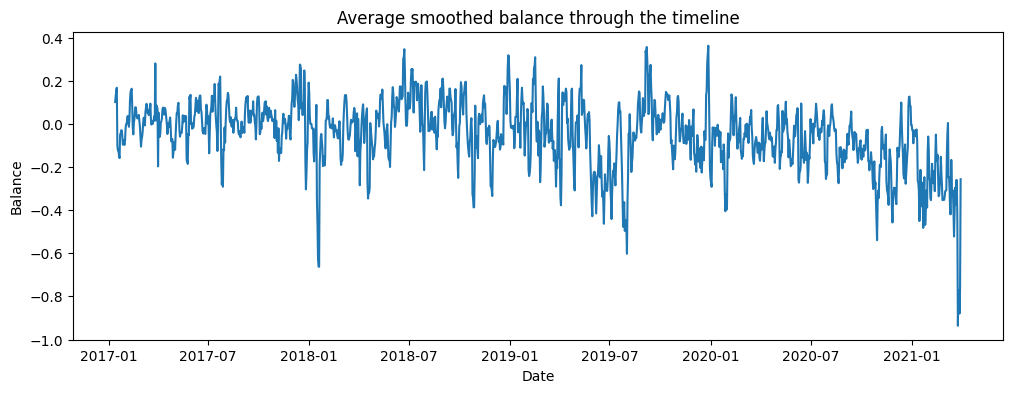

In [4]:
df['common_smoothing'] = common_moving_average(df['Balance'], 5)
plot_time_series(df, x=df.index, y='common_smoothing', title='Average smoothed balance through the timeline', ylabel='Balance')
print(f'p-value критерия Дики-Фуллера: {adfuller(df['common_smoothing'].dropna().values, autolag='AIC')[1]}')

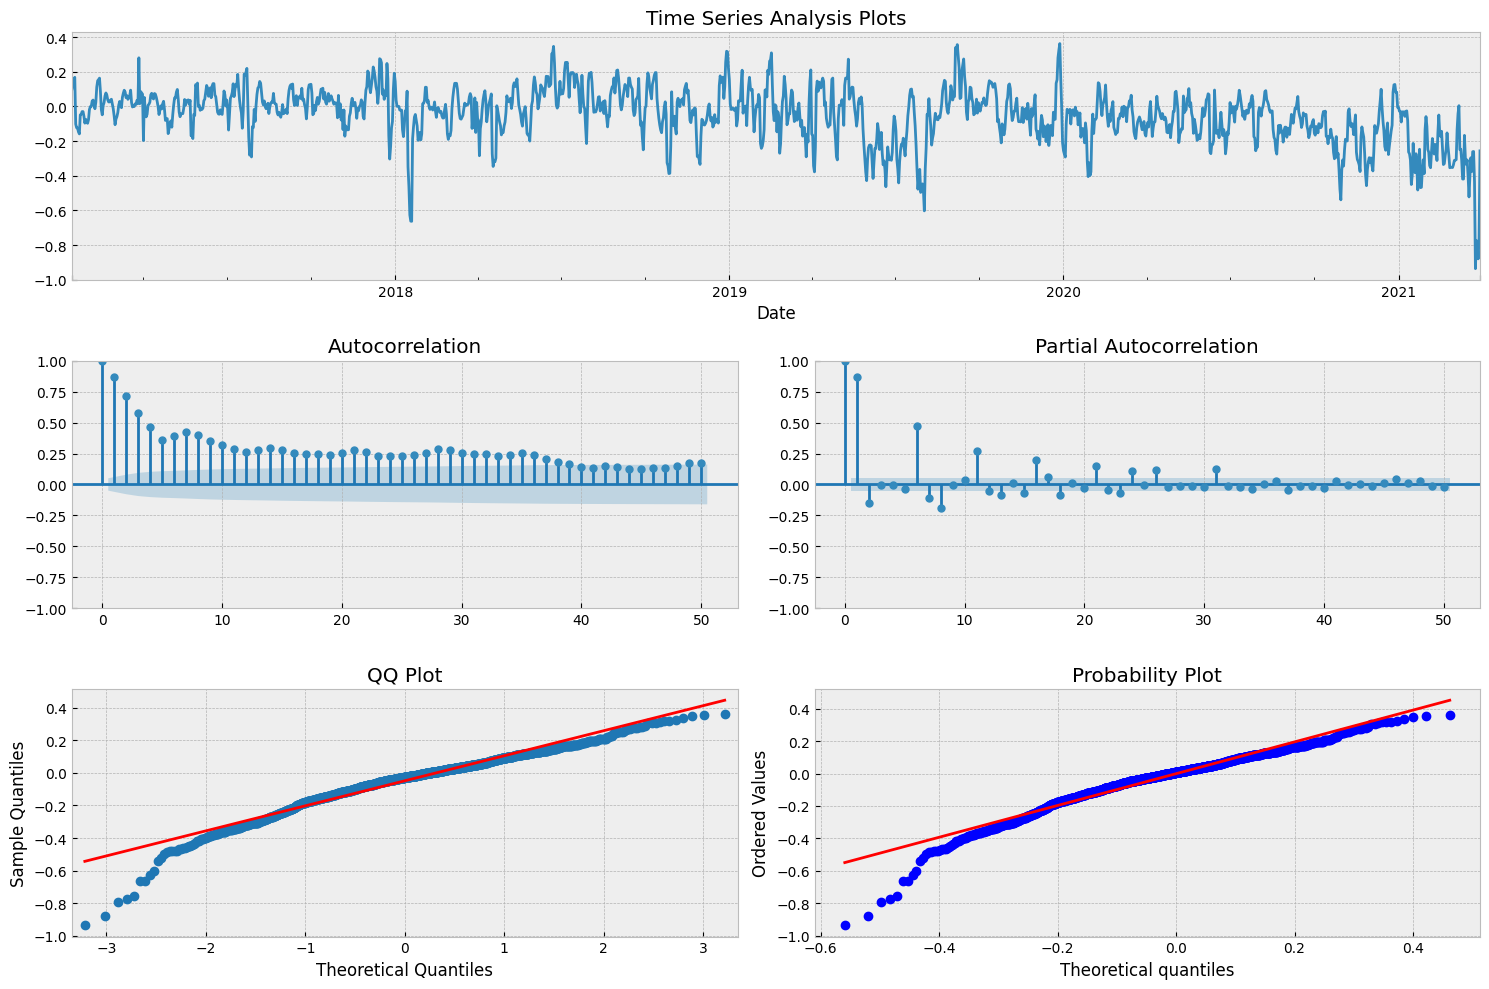

In [5]:
tsplot(df['common_smoothing'].dropna(), lags=50)

## Обыкновенное экспоненциальное сглаживание

Критерий Дики-Фуллера: 0.0026184350270241634


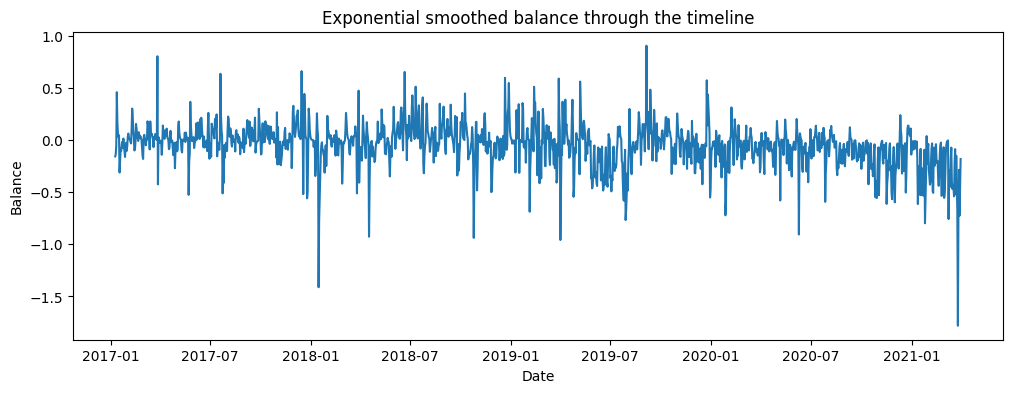

In [6]:
df['common_exponential_smoothing'] = exponential_smoothing(df['Balance'], 0.6)
plot_time_series(
    df, x=df.index, y='common_exponential_smoothing', title='Exponential smoothed balance through the timeline', ylabel='Balance'
)
print(f'Критерий Дики-Фуллера: {adfuller(df['common_exponential_smoothing'].dropna().values, autolag='AIC')[1]}')

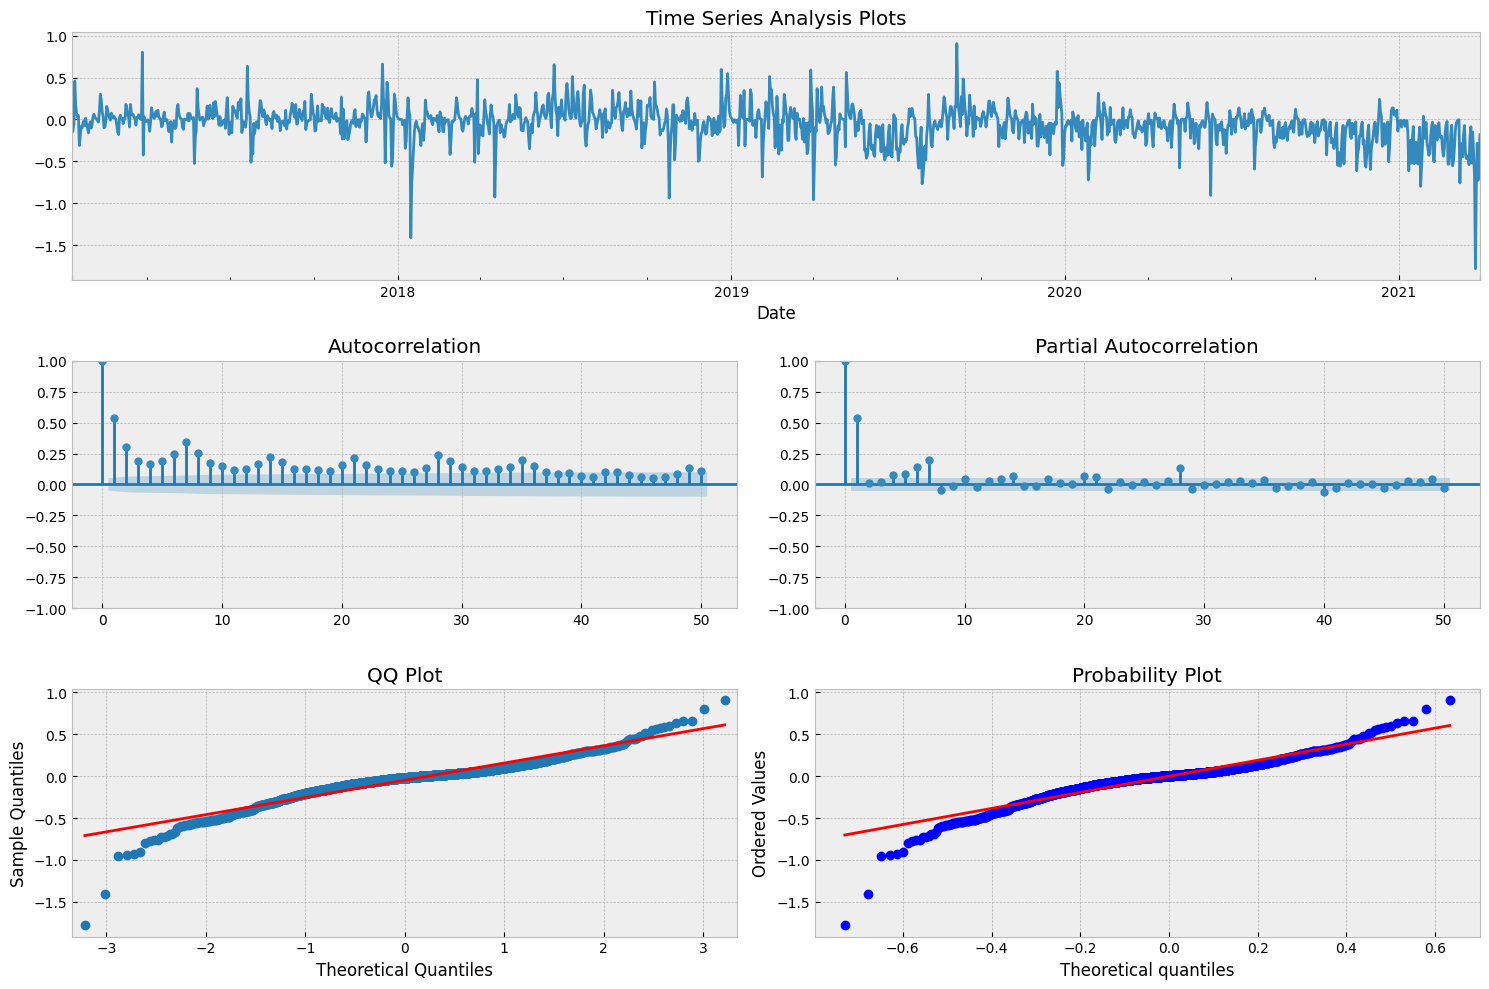

In [7]:
tsplot(df['common_exponential_smoothing'], lags=50)

## Двойное экспоненциальное сглаживание

Критерий Дики-Фуллера: 0.0002256311816065404


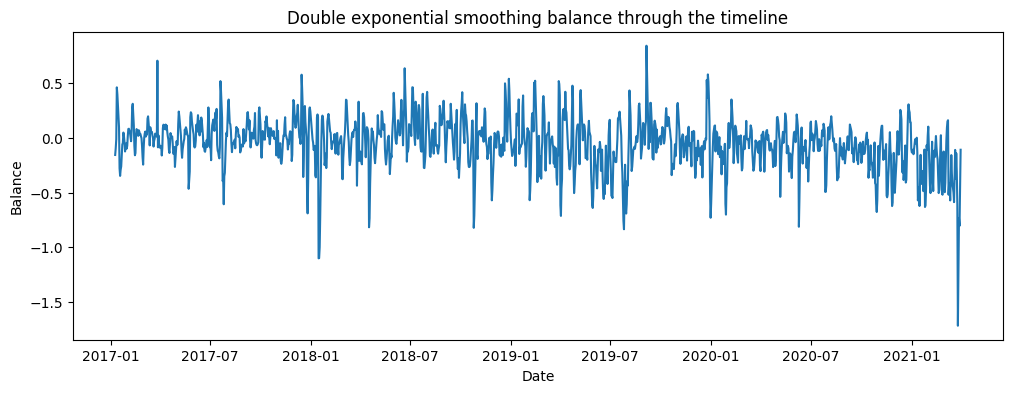

In [8]:
df['double_exponential_smoothing'] = double_exponential_smoothing(df['Balance'], 0.35, 0.5)
plot_time_series(
    df, x=df.index, y='double_exponential_smoothing', title='Double exponential smoothing balance through the timeline', ylabel='Balance'
)
print(f'Критерий Дики-Фуллера: {adfuller(df['double_exponential_smoothing'].dropna().values, autolag='AIC')[1]}')

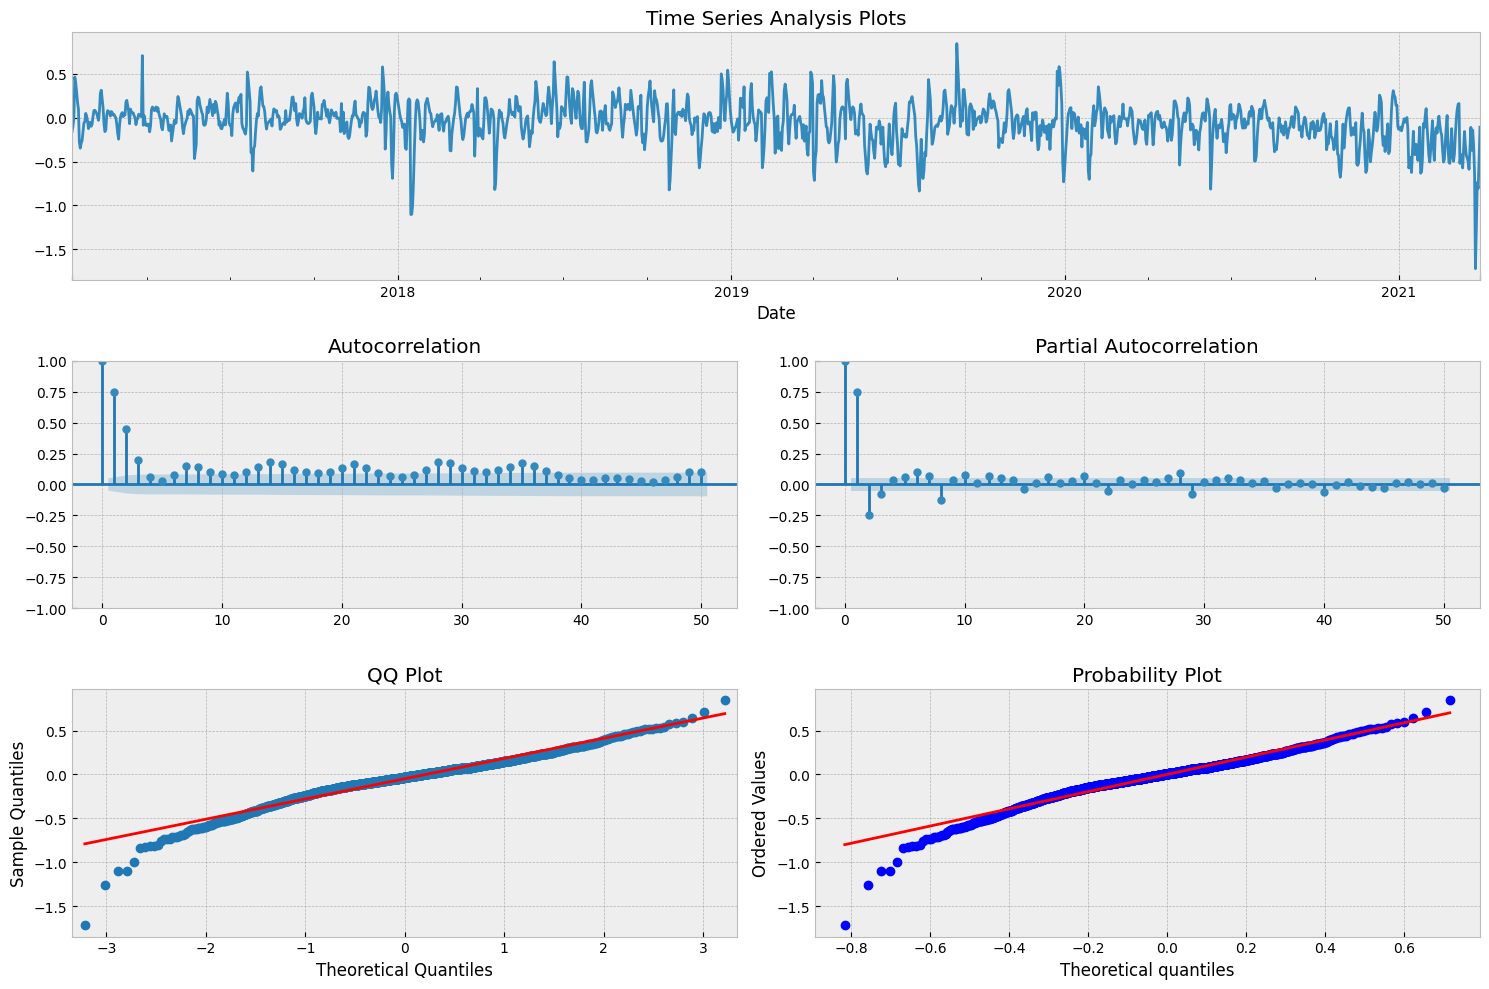

In [9]:
tsplot(df['double_exponential_smoothing'], lags=50)

# Построение модели ARIMA

Согласно теореме Вольда, можно подобрать авторегрессионную модель ARIMA к временному ряду с ранее подобранными гиперпараметры (см. ноутбук Dataset_overview.ipynb).


SARIMA простой и хороший базовый вариант авторегрессионной модели, может работать с сезонностью и дифференциированным рядом.

In [10]:
ps = range(0, 8)
ds = range(0, 2)
qs = range(0, 8)

Ps = range(0, 2)
Ds = range(0, 2)
Qs = range(0, 2)

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

1024

In [11]:
train = df['common_exponential_smoothing'][df['common_exponential_smoothing'].index < datetime.datetime(2021, 1, 1)]
oot = df['common_exponential_smoothing'][df['common_exponential_smoothing'].index >= datetime.datetime(2021, 1, 1)]

# train = df['Balance'][df['Balance'].index < datetime.datetime(2021, 1, 1)]
# oot = df['Balance'][df['Balance'].index >= datetime.datetime(2021, 1, 1)]

In [84]:
%%time
results = []
best_model = None
best_aic = float("inf")
best_parameters = None

for parameters in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=(parameters[0], parameters[1], parameters[2]), 
            seasonal_order=(parameters[3], parameters[4], parameters[5], 7)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', parameters)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_parameters = parameters
    results.append([parameters, model.aic])

  6%|████▌                                                                              | 57/1024 [00:42<24:56,  1.55s/it]

wrong parameters: (0, 0, 7, 0, 0, 1)


  6%|████▊                                                                              | 59/1024 [00:44<21:12,  1.32s/it]

wrong parameters: (0, 0, 7, 0, 1, 1)


  6%|████▉                                                                              | 61/1024 [00:45<15:20,  1.05it/s]

wrong parameters: (0, 0, 7, 1, 0, 1)


  6%|█████                                                                              | 63/1024 [00:47<16:04,  1.00s/it]

wrong parameters: (0, 0, 7, 1, 1, 1)


 12%|█████████▋                                                                        | 121/1024 [01:51<27:54,  1.85s/it]

wrong parameters: (0, 1, 7, 0, 0, 1)


 12%|█████████▊                                                                        | 123/1024 [01:53<22:03,  1.47s/it]

wrong parameters: (0, 1, 7, 0, 1, 1)


 12%|██████████                                                                        | 125/1024 [01:54<16:03,  1.07s/it]

wrong parameters: (0, 1, 7, 1, 0, 1)


 12%|██████████▏                                                                       | 127/1024 [01:56<14:59,  1.00s/it]

wrong parameters: (0, 1, 7, 1, 1, 1)


 18%|██████████████▊                                                                   | 185/1024 [03:05<32:01,  2.29s/it]

wrong parameters: (1, 0, 7, 0, 0, 1)


 18%|██████████████▉                                                                   | 187/1024 [03:07<24:35,  1.76s/it]

wrong parameters: (1, 0, 7, 0, 1, 1)


 18%|███████████████▏                                                                  | 189/1024 [03:08<17:41,  1.27s/it]

wrong parameters: (1, 0, 7, 1, 0, 1)


 19%|███████████████▎                                                                  | 191/1024 [03:11<17:27,  1.26s/it]

wrong parameters: (1, 0, 7, 1, 1, 1)


 24%|███████████████████▉                                                              | 249/1024 [04:31<32:15,  2.50s/it]

wrong parameters: (1, 1, 7, 0, 0, 1)


 25%|████████████████████                                                              | 251/1024 [04:33<23:59,  1.86s/it]

wrong parameters: (1, 1, 7, 0, 1, 1)


 25%|████████████████████▎                                                             | 253/1024 [04:34<17:54,  1.39s/it]

wrong parameters: (1, 1, 7, 1, 0, 1)


 25%|████████████████████▌                                                             | 257/1024 [04:36<11:07,  1.15it/s]

wrong parameters: (1, 1, 7, 1, 1, 1)


 31%|█████████████████████████                                                         | 313/1024 [06:00<30:03,  2.54s/it]

wrong parameters: (2, 0, 7, 0, 0, 1)


 31%|█████████████████████████▏                                                        | 315/1024 [06:02<23:14,  1.97s/it]

wrong parameters: (2, 0, 7, 0, 1, 1)


 31%|█████████████████████████▍                                                        | 317/1024 [06:04<17:23,  1.48s/it]

wrong parameters: (2, 0, 7, 1, 0, 1)


 31%|█████████████████████████▌                                                        | 319/1024 [06:07<17:24,  1.48s/it]

wrong parameters: (2, 0, 7, 1, 1, 1)


 37%|██████████████████████████████▏                                                   | 377/1024 [07:47<32:09,  2.98s/it]

wrong parameters: (2, 1, 7, 0, 0, 1)


 37%|██████████████████████████████▎                                                   | 379/1024 [07:50<23:37,  2.20s/it]

wrong parameters: (2, 1, 7, 0, 1, 1)


 37%|██████████████████████████████▌                                                   | 381/1024 [07:52<17:54,  1.67s/it]

wrong parameters: (2, 1, 7, 1, 0, 1)


 38%|██████████████████████████████▊                                                   | 385/1024 [07:55<12:02,  1.13s/it]

wrong parameters: (2, 1, 7, 1, 1, 1)


 43%|███████████████████████████████████▎                                              | 441/1024 [09:36<28:32,  2.94s/it]

wrong parameters: (3, 0, 7, 0, 0, 1)


 43%|███████████████████████████████████▍                                              | 443/1024 [09:39<21:56,  2.27s/it]

wrong parameters: (3, 0, 7, 0, 1, 1)


 43%|███████████████████████████████████▋                                              | 445/1024 [09:41<16:54,  1.75s/it]

wrong parameters: (3, 0, 7, 1, 0, 1)


 44%|███████████████████████████████████▉                                              | 449/1024 [09:46<12:03,  1.26s/it]

wrong parameters: (3, 0, 7, 1, 1, 1)


 49%|████████████████████████████████████████▍                                         | 505/1024 [11:44<29:50,  3.45s/it]

wrong parameters: (3, 1, 7, 0, 0, 1)


 50%|████████████████████████████████████████▌                                         | 507/1024 [11:46<21:08,  2.45s/it]

wrong parameters: (3, 1, 7, 0, 1, 1)


 50%|████████████████████████████████████████▊                                         | 509/1024 [11:49<16:58,  1.98s/it]

wrong parameters: (3, 1, 7, 1, 0, 1)


 50%|█████████████████████████████████████████                                         | 513/1024 [11:53<11:32,  1.36s/it]

wrong parameters: (3, 1, 7, 1, 1, 1)


 56%|█████████████████████████████████████████████▌                                    | 569/1024 [13:48<23:16,  3.07s/it]

wrong parameters: (4, 0, 7, 0, 0, 1)


 56%|█████████████████████████████████████████████▋                                    | 571/1024 [13:51<17:48,  2.36s/it]

wrong parameters: (4, 0, 7, 0, 1, 1)


 56%|█████████████████████████████████████████████▉                                    | 573/1024 [13:53<14:07,  1.88s/it]

wrong parameters: (4, 0, 7, 1, 0, 1)


 56%|██████████████████████████████████████████████▏                                   | 577/1024 [13:58<10:20,  1.39s/it]

wrong parameters: (4, 0, 7, 1, 1, 1)


 62%|██████████████████████████████████████████████████▋                               | 633/1024 [16:10<23:03,  3.54s/it]

wrong parameters: (4, 1, 7, 0, 0, 1)


 62%|██████████████████████████████████████████████████▊                               | 635/1024 [16:13<16:29,  2.54s/it]

wrong parameters: (4, 1, 7, 0, 1, 1)


 62%|███████████████████████████████████████████████████                               | 637/1024 [16:15<13:11,  2.05s/it]

wrong parameters: (4, 1, 7, 1, 0, 1)


 63%|███████████████████████████████████████████████████▎                              | 641/1024 [16:21<09:49,  1.54s/it]

wrong parameters: (4, 1, 7, 1, 1, 1)


 68%|███████████████████████████████████████████████████████▊                          | 697/1024 [18:28<18:45,  3.44s/it]

wrong parameters: (5, 0, 7, 0, 0, 1)


 68%|███████████████████████████████████████████████████████▉                          | 699/1024 [18:31<13:30,  2.50s/it]

wrong parameters: (5, 0, 7, 0, 1, 1)


 68%|████████████████████████████████████████████████████████▏                         | 701/1024 [18:33<10:32,  1.96s/it]

wrong parameters: (5, 0, 7, 1, 0, 1)


 69%|████████████████████████████████████████████████████████▍                         | 705/1024 [18:39<07:52,  1.48s/it]

wrong parameters: (5, 0, 7, 1, 1, 1)


 74%|████████████████████████████████████████████████████████████▉                     | 761/1024 [21:07<16:47,  3.83s/it]

wrong parameters: (5, 1, 7, 0, 0, 1)


 75%|█████████████████████████████████████████████████████████████                     | 763/1024 [21:10<11:52,  2.73s/it]

wrong parameters: (5, 1, 7, 0, 1, 1)


 75%|█████████████████████████████████████████████████████████████▎                    | 765/1024 [21:12<09:27,  2.19s/it]

wrong parameters: (5, 1, 7, 1, 0, 1)


 75%|█████████████████████████████████████████████████████████████▍                    | 767/1024 [21:18<10:03,  2.35s/it]

wrong parameters: (5, 1, 7, 1, 1, 1)


 81%|██████████████████████████████████████████████████████████████████                | 825/1024 [23:42<12:19,  3.72s/it]

wrong parameters: (6, 0, 7, 0, 0, 1)


 81%|██████████████████████████████████████████████████████████████████▏               | 827/1024 [23:45<08:45,  2.67s/it]

wrong parameters: (6, 0, 7, 0, 1, 1)


 81%|██████████████████████████████████████████████████████████████████▍               | 829/1024 [23:48<06:52,  2.12s/it]

wrong parameters: (6, 0, 7, 1, 0, 1)


 81%|██████████████████████████████████████████████████████████████████▌               | 831/1024 [23:53<07:42,  2.39s/it]

wrong parameters: (6, 0, 7, 1, 1, 1)


 87%|███████████████████████████████████████████████████████████████████████▏          | 889/1024 [26:47<10:42,  4.76s/it]

wrong parameters: (6, 1, 7, 0, 0, 1)


 87%|███████████████████████████████████████████████████████████████████████▎          | 891/1024 [26:51<07:31,  3.39s/it]

wrong parameters: (6, 1, 7, 0, 1, 1)


 87%|███████████████████████████████████████████████████████████████████████▌          | 893/1024 [26:53<05:37,  2.57s/it]

wrong parameters: (6, 1, 7, 1, 0, 1)


 87%|███████████████████████████████████████████████████████████████████████▋          | 895/1024 [27:01<06:25,  2.99s/it]

wrong parameters: (6, 1, 7, 1, 1, 1)


 88%|████████████████████████████████████████████████████████████████████████          | 900/1024 [27:04<03:10,  1.54s/it]

wrong parameters: (7, 0, 0, 1, 0, 0)
wrong parameters: (7, 0, 0, 1, 0, 1)
wrong parameters: (7, 0, 0, 1, 1, 0)
wrong parameters: (7, 0, 0, 1, 1, 1)


 89%|████████████████████████████████████████████████████████████████████████▋         | 908/1024 [27:10<02:16,  1.17s/it]

wrong parameters: (7, 0, 1, 1, 0, 0)
wrong parameters: (7, 0, 1, 1, 0, 1)
wrong parameters: (7, 0, 1, 1, 1, 0)
wrong parameters: (7, 0, 1, 1, 1, 1)


 89%|█████████████████████████████████████████████████████████████████████████▎        | 916/1024 [27:17<02:25,  1.34s/it]

wrong parameters: (7, 0, 2, 1, 0, 0)
wrong parameters: (7, 0, 2, 1, 0, 1)
wrong parameters: (7, 0, 2, 1, 1, 0)
wrong parameters: (7, 0, 2, 1, 1, 1)


 90%|█████████████████████████████████████████████████████████████████████████▉        | 924/1024 [27:25<02:37,  1.58s/it]

wrong parameters: (7, 0, 3, 1, 0, 0)
wrong parameters: (7, 0, 3, 1, 0, 1)
wrong parameters: (7, 0, 3, 1, 1, 0)
wrong parameters: (7, 0, 3, 1, 1, 1)


 91%|██████████████████████████████████████████████████████████████████████████▋       | 932/1024 [27:35<02:47,  1.82s/it]

wrong parameters: (7, 0, 4, 1, 0, 0)
wrong parameters: (7, 0, 4, 1, 0, 1)
wrong parameters: (7, 0, 4, 1, 1, 0)
wrong parameters: (7, 0, 4, 1, 1, 1)


 92%|███████████████████████████████████████████████████████████████████████████▎      | 940/1024 [27:46<02:55,  2.09s/it]

wrong parameters: (7, 0, 5, 1, 0, 0)
wrong parameters: (7, 0, 5, 1, 0, 1)
wrong parameters: (7, 0, 5, 1, 1, 0)
wrong parameters: (7, 0, 5, 1, 1, 1)


 93%|███████████████████████████████████████████████████████████████████████████▉      | 948/1024 [27:59<03:07,  2.46s/it]

wrong parameters: (7, 0, 6, 1, 0, 0)
wrong parameters: (7, 0, 6, 1, 0, 1)
wrong parameters: (7, 0, 6, 1, 1, 0)
wrong parameters: (7, 0, 6, 1, 1, 1)


 93%|████████████████████████████████████████████████████████████████████████████▎     | 953/1024 [28:01<01:25,  1.21s/it]

wrong parameters: (7, 0, 7, 0, 0, 1)


 93%|████████████████████████████████████████████████████████████████████████████▍     | 955/1024 [28:04<01:33,  1.35s/it]

wrong parameters: (7, 0, 7, 0, 1, 1)
wrong parameters: (7, 0, 7, 1, 0, 0)
wrong parameters: (7, 0, 7, 1, 0, 1)
wrong parameters: (7, 0, 7, 1, 1, 0)
wrong parameters: (7, 0, 7, 1, 1, 1)


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 964/1024 [28:08<00:51,  1.17it/s]

wrong parameters: (7, 1, 0, 1, 0, 0)
wrong parameters: (7, 1, 0, 1, 0, 1)
wrong parameters: (7, 1, 0, 1, 1, 0)
wrong parameters: (7, 1, 0, 1, 1, 1)


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 972/1024 [28:15<01:03,  1.22s/it]

wrong parameters: (7, 1, 1, 1, 0, 0)
wrong parameters: (7, 1, 1, 1, 0, 1)
wrong parameters: (7, 1, 1, 1, 1, 0)
wrong parameters: (7, 1, 1, 1, 1, 1)


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 980/1024 [28:24<01:12,  1.65s/it]

wrong parameters: (7, 1, 2, 1, 0, 0)
wrong parameters: (7, 1, 2, 1, 0, 1)
wrong parameters: (7, 1, 2, 1, 1, 0)
wrong parameters: (7, 1, 2, 1, 1, 1)


 96%|███████████████████████████████████████████████████████████████████████████████   | 988/1024 [28:34<01:06,  1.85s/it]

wrong parameters: (7, 1, 3, 1, 0, 0)
wrong parameters: (7, 1, 3, 1, 0, 1)
wrong parameters: (7, 1, 3, 1, 1, 0)
wrong parameters: (7, 1, 3, 1, 1, 1)


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 996/1024 [28:45<00:56,  2.02s/it]

wrong parameters: (7, 1, 4, 1, 0, 0)
wrong parameters: (7, 1, 4, 1, 0, 1)
wrong parameters: (7, 1, 4, 1, 1, 0)
wrong parameters: (7, 1, 4, 1, 1, 1)


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 1004/1024 [28:59<00:51,  2.59s/it]

wrong parameters: (7, 1, 5, 1, 0, 0)
wrong parameters: (7, 1, 5, 1, 0, 1)
wrong parameters: (7, 1, 5, 1, 1, 0)
wrong parameters: (7, 1, 5, 1, 1, 1)


 99%|████████████████████████████████████████████████████████████████████████████████ | 1012/1024 [29:12<00:31,  2.66s/it]

wrong parameters: (7, 1, 6, 1, 0, 0)
wrong parameters: (7, 1, 6, 1, 0, 1)
wrong parameters: (7, 1, 6, 1, 1, 0)
wrong parameters: (7, 1, 6, 1, 1, 1)


 99%|████████████████████████████████████████████████████████████████████████████████▍| 1017/1024 [29:14<00:09,  1.31s/it]

wrong parameters: (7, 1, 7, 0, 0, 1)


100%|█████████████████████████████████████████████████████████████████████████████████| 1024/1024 [29:18<00:00,  1.72s/it]

wrong parameters: (7, 1, 7, 0, 1, 1)
wrong parameters: (7, 1, 7, 1, 0, 0)
wrong parameters: (7, 1, 7, 1, 0, 1)
wrong parameters: (7, 1, 7, 1, 1, 0)
wrong parameters: (7, 1, 7, 1, 1, 1)
CPU times: user 1h 19min 10s, sys: 3h 2min 43s, total: 4h 21min 53s
Wall time: 29min 18s


In [85]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
print(result_table.sort_values(by='aic', ascending=True).head())
# На полном наборе данных без сглаживания (3, 0, 7, 1, 1, 0)
# На train с экспоненциальным сглаживанием (5, 0, 3, 1, 0, 1)
print(best_parameters)

             parameters          aic
629  (5, 0, 3, 1, 0, 1) -1261.999317
733  (6, 0, 1, 1, 0, 1) -1261.562723
613  (5, 0, 1, 1, 0, 1) -1261.353798
621  (5, 0, 2, 1, 0, 1) -1261.090942
157  (1, 0, 4, 1, 0, 1) -1260.486547
(5, 0, 3, 1, 0, 1)


In [12]:
best_model = sm.tsa.statespace.SARIMAX(
    train,
    order=(3, 0, 7),
    seasonal_order=(1, 1, 0, 7)
).fit(disp=-1)

In [13]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:       common_exponential_smoothing   No. Observations:                 1453
Model:             SARIMAX(3, 0, 7)x(1, 1, [], 7)   Log Likelihood                 634.565
Date:                            Sun, 14 Apr 2024   AIC                          -1245.130
Time:                                    21:25:05   BIC                          -1181.811
Sample:                                01-09-2017   HQIC                         -1221.498
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4590      0.024     19.529      0.000       0.413       0.505
ar.L2          0.0244      0.030   

## Валидация построенной модели

Критерий Стьюдента: p-value=0.591454016598816
ADF Statistic: -37.95158377026042
p-value: 0.0
Critial Values:
	1%, -3.4348616379354793
Critial Values:
	5%, -2.8635325860671696
Critial Values:
	10%, -2.567830836482784


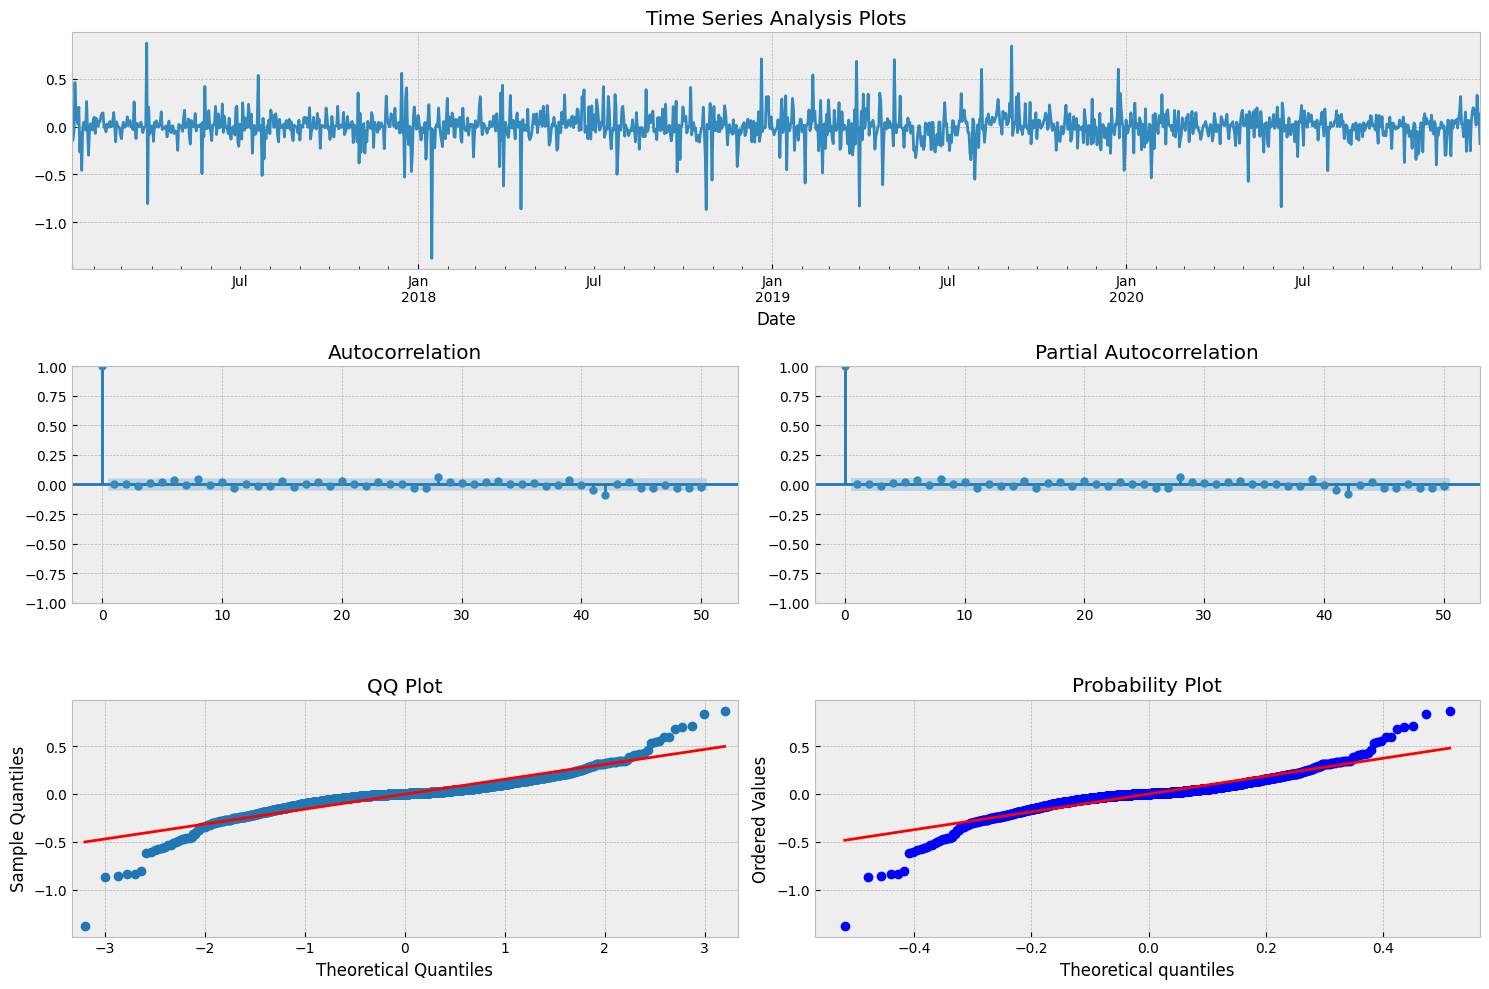

In [14]:
tsplot(best_model.resid, lags=50)

# Равенство нулю матожидания остатков
student_result = stats.ttest_1samp(best_model.resid, 0)
print(f"Критерий Стьюдента: p-value={student_result[1]}")

adfuller_result = adfuller(best_model.resid)
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).

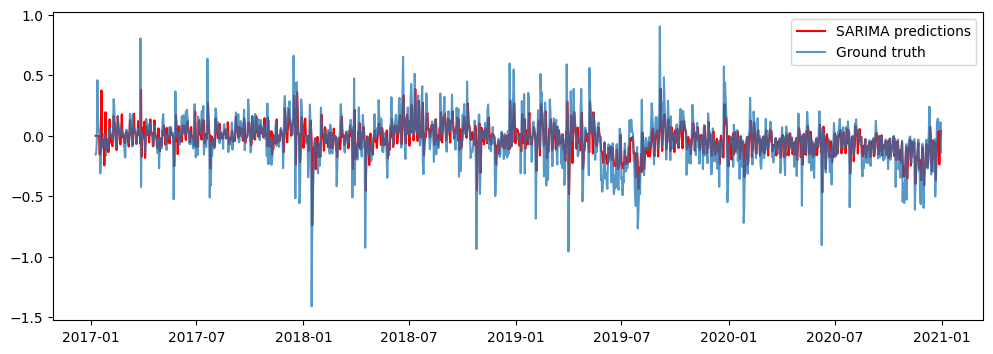

In [15]:
# Обучающая выборка, базовая работоспособность модели
fittedvalues = best_model.fittedvalues
actual = train
plt.figure(figsize=(12, 4))
plt.plot(fittedvalues, color='r', label="SARIMA predictions")
plt.plot(actual, label="Ground truth", alpha=0.75)
plt.legend();

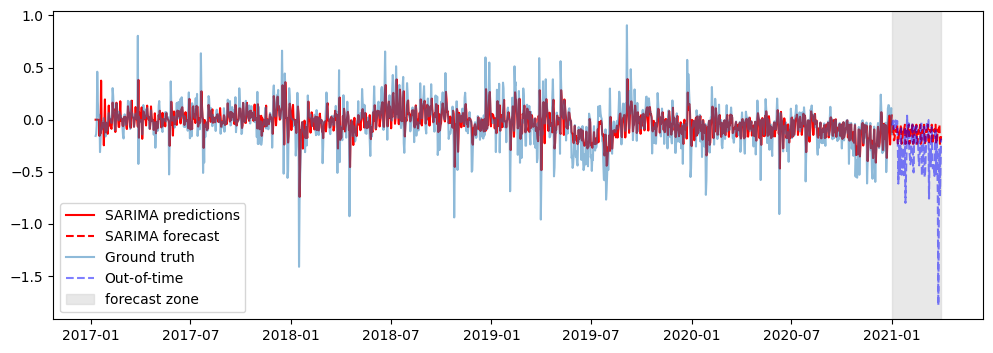

In [16]:
fittedvalues = best_model.fittedvalues
forecast_start = oot.index[0]  # datetime.datetime(2021, 4, 1)
forecast_end = oot.index[-1]  # datetime.datetime(2021, 4, 28)
# forecast = best_model.forecast(steps=21)
forecast = best_model.predict(start=forecast_start, end=forecast_end)
# actual = df['Balance']

plt.figure(figsize=(12, 4))
plt.plot(fittedvalues, color='r', label="SARIMA predictions")
plt.plot(forecast, color='r', linestyle='--', label="SARIMA forecast")
# plt.plot(actual, label="Ground truth", alpha=0.5)
plt.plot(train, label="Ground truth", alpha=0.5)
plt.plot(oot, color='b', label="Out-of-time", linestyle="--", alpha=0.5)
plt.axvspan(forecast_start, forecast_end, alpha=0.5, color='lightgrey', label='forecast zone')

plt.legend();

In [17]:
print('MAE:', mean_absolute_error(oot.values, forecast.values))
bs = BusinessSimulation()
print('Business metric:', bs.evaluate_performance(oot.values, forecast.values))

MAE: 0.19818068582356585
Business metric: -1.149870917982606


## Полученные метрики на out of time тестовой выборке (2021 год)
- MAE на временном ряде с примененным экспоненциальным сглаживанием = 0.198
- MAE на временном ряде без сглаживания = 0.248
- Бизнес метрика на временном ряде с примененным экспоненциальным сглаживанием = -1.1499
- Бизнес метрика на временном ряде без сглаживания = -1.1992

In [19]:
with open('../data/artifacts/sarima_autoregressor.pkl', 'wb') as file:
    pickle.dump(best_model, file)